In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
import os
import time




# a simple conversion from cl's to dl's
def l_to_dl(lp):
    return lp*(lp+1.)/2./np.pi



Metal device set to: Apple M1 Pro


2023-03-25 10:51:41.147870: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-25 10:51:41.147980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
#plotting settings
plot_params= {
    'figure.figsize': (10,8),
    'axes.labelsize': 15,
    'axes.grid': True,
    'grid.alpha': 0.2,
    'grid.linestyle':'--',
    'axes.grid.which': 'both',
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.fontsize': 13,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.major.size': 7,
    'xtick.minor.size': 3,
    'ytick.major.size': 7,
    'ytick.minor.size': 3,
    'axes.titlesize': 20,
    'xtick.major.size':5,
    'ytick.major.size':5,
    'xtick.major.pad':10,
    'ytick.major.pad':5,
    'xtick.direction':'in',
    'ytick.direction':'in',
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    
}
plt.rcParams.update(plot_params)

In [3]:
def tSZ_kappa(hmf='T10',
        press_profile='B12',
        concentration='B13', 
       zmin=0.005, zmax=6.,
       Mmin=1e11, Mmax=1e16, 
       xout=4, B=1.25, P0_B12=11, out='tot'):
    
    """function to easily compute the tSZ-CMB lensing power spectrum using class_sz.
    
    Input:
    
    hmf: halo mass function --'T10','T08200m','B15' (default:'T10'-- Tinker+2010 )
    press_profile: pressure profile -- 'P13','A10','B12'(default:'B12'-- Battaglia+2012)
    concentration: concentration parameter --'D08','K10','DM14' (default: 'B13'-- Bhattacharya+2013)
    zmin: minimum redshift 
    zmax: maximum redshift 
    Mmin: minimum mass
    Mmax: maximum mass 
    xout= outer radius/R_200c (default: 4)
    out: "all" if you want to return 1-h & 2-h terms in addition to total, 
    "tot" if you just want the total tSZ power spectrum
    
    Output:
    
    if out is set to 'tot':
    ell and total tSZ-kappa power spectrum
    
    if out is set to 'all':
    
    ell, 1-halo, 2-halo, total tSZ-kappa power spectrum
    """
    
    
    # the parameters needed for cosmology:
    # use the last column of Planck 2018 (https://arxiv.org/pdf/1807.06209.pdf) Table 2
    # TT,TE,EE+lowE+lensing+BAO
    cosmo_params = {
    'omega_b': 0.02242,
    'omega_cdm':  0.11933,
    'H0': 67.66, # use H0 because this is what is used by the emulators.
    'tau_reio': 0.0561,
    'ln10^{10}A_s': 3.047,
    'n_s': 0.9665,
    
    'k_pivot': 0.05,
    'N_ncdm': 1,
    'N_ur': 2.0328,
    'm_ncdm': 0.06}

    
    tSZ_dict={'output':'tSZ_lens_1h, tSZ_lens_2h',
        
        'ell_max' : 9950.0,
        'ell_min' : 50,
        'dell': 50.,
        
        # mass function/pressure profile/concentration prescriptions 
        'mass function' : hmf,
        'hm_consistency': 0,             
        'pressure profile': press_profile, 
        'concentration parameter': concentration,
    
        #P(k) settings for mass function
        'k_per_decade_class_sz':80.,
        'k_min_for_pk_class_sz':1e-4,
        'k_max_for_pk_class_sz':7.,
        
        #integration precision settings
        'redshift_epsrel': 1e-4,
        'redshift_epsabs': 1e-100,
        'mass_epsrel':1e-4,
        'mass_epsabs':1e-100,
        
        #redshift and mass bounds
        'z_min' : zmin,
        'z_max' : zmax,
        'M_min' : Mmin*cosmo_params['H0']/100.,
        'M_max' : Mmax*cosmo_params['H0']/100.,
        
        # pressure profile params:
        
        'delta for electron pressure':'200c',
        'n_z_dydz' : 500,
        'n_z_pressure_profile': 80,
        'n_m_pressure_profile' : 80,
        #'n_ell_pressure_profile' : 80,
        
        'x_outSZ': xout,
        'truncate_wrt_rvir': 0,

        'pressure_profile_epsrel':1e-4,
        'pressure_profile_epsabs':1e-100}
        
    if press_profile =='B12':
        
        tSZ_dict['P0_B12']=P0_B12
    
    elif press_profile=='A10' or press_profile=='P13':
        tSZ_dict['B']=B

    M = Class()
    M.set(cosmo_params)
    M.set(tSZ_dict)
    M.compute()
    cl_yk= M.cl_y_kcmb()    # Note that this function returns l*(l+1) * C_ell/(2pi)
    
    cl_ell=np.array(cl_yk['ell'])
    cl_1h=np.array(cl_yk['1h'])/cl_ell**2/(cl_ell+1)/1e6*(2*np.pi)
    cl_2h=np.array(cl_yk['2h'])/cl_ell**2/(cl_ell+1)/1e6*(2*np.pi)
    
    cl_tot=cl_1h+cl_2h
    
    if out=='all':
        
        return cl_ell, cl_1h, cl_2h, cl_tot
    
    elif out=='tot':
        
        return cl_ell, cl_tot
    


In [4]:
cl_yk_ell_Battaglia, cl_yk_1h_Battaglia, cl_yk_2h_Battaglia, cl_yk_tot_T10_B13_B12=tSZ_kappa(out='all')

cl_yk_ell_Arnaud, cl_yk_1h_Arnaud, cl_yk_2h_Arnaud, cl_yk_tot_Arnaud=tSZ_kappa(press_profile='A10', B=1.7,out='all')

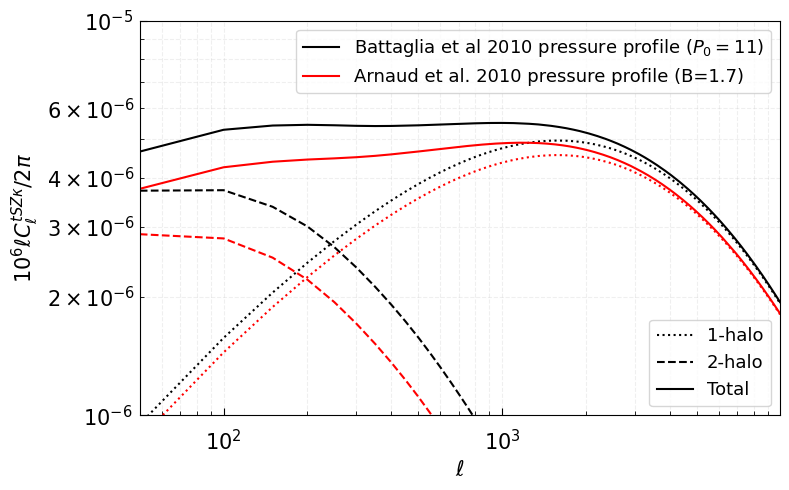

In [5]:
plt.figure(figsize=(8,5))
ax=plt.subplot(111)
plt.xscale('log')
plt.yscale('log')

plt.plot(cl_yk_ell_Battaglia, 1e6*cl_yk_ell_Battaglia*cl_yk_1h_Battaglia/(2*np.pi), c='black', label='1-halo', ls=':')
plt.plot(cl_yk_ell_Battaglia, 1e6*cl_yk_ell_Battaglia*cl_yk_2h_Battaglia/(2*np.pi), c='black', label='2-halo', ls='--')
l1,=plt.plot(cl_yk_ell_Battaglia, 1e6*cl_yk_ell_Battaglia*cl_yk_tot_T10_B13_B12/(2*np.pi), c='black', label='Total')
leg1=plt.legend(loc='lower right')


plt.plot(cl_yk_ell_Arnaud, 1e6*cl_yk_ell_Arnaud*cl_yk_1h_Arnaud/(2*np.pi), c='red', label='1-halo', ls=':')
plt.plot(cl_yk_ell_Arnaud, 1e6*cl_yk_ell_Arnaud*cl_yk_2h_Arnaud/(2*np.pi), c='red', label='2-halo', ls='--')
l2,=plt.plot(cl_yk_ell_Arnaud, 1e6*cl_yk_ell_Arnaud*cl_yk_tot_Arnaud/(2*np.pi), c='red', label='Total')




leg2=plt.legend([l1,l2],[r"Battaglia et al 2010 pressure profile ($P_0=11$)","Arnaud et al. 2010 pressure profile (B=1.7)"])

ax.add_artist(leg1)

plt.xlim([50, 9950])
plt.ylim(1e-6,1e-5)
plt.ylabel(r'$10^{6}\ell C_{\ell}^{tSZ \kappa}/2\pi$')
plt.xlabel('$\ell$')
#plt.yscale('linear')
plt.tight_layout()
plt.savefig('figures/tSZk_1h_2h.pdf')